In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/shua784/anaconda3/lib/python3.6/site-packages/flopy


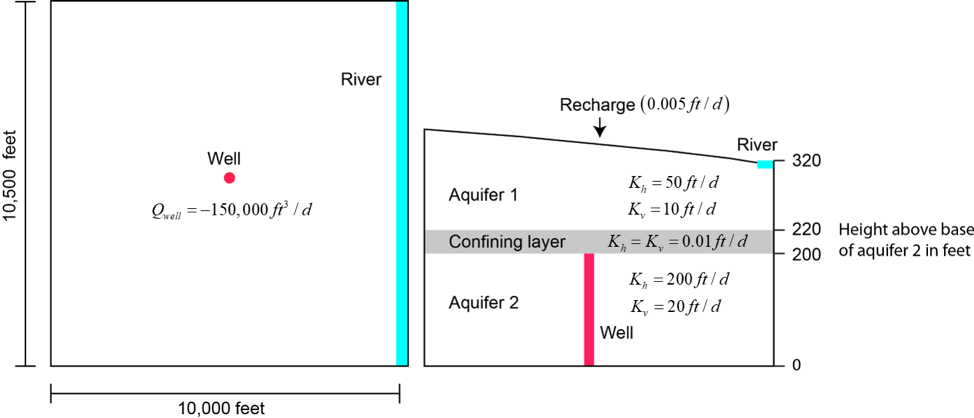

# Developing time varying boundary packages

We will base this example on example 1 in [Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086](https://doi.org/10.3133/ofr20161086).

We will start by recreating the steady state model and will then convert that model into a transient model with time varying boundary conditions.

In [2]:
ws = 'data/ex03a'
name = 'ex03a'
exe_name = os.path.abspath('../bin/mf6')
assert os.path.isfile(exe_name)

## Steady-State Model

This is simply a recreation of the MODFLOW 6 model that was completed in the previous notebook.

In [3]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, sim_ws=ws)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

# dis
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220, 200, 0]
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# ic
ic = flopy.mf6.ModflowGwfic(gwf, strt=320.)

# npf
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype = [1, 0, 0]
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              save_specific_discharge=True,
                              icelltype=icelltype,
                              k=kh,
                              k33=kv)

# rch
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005)

# wel
wel_spd = {0: [[(2, 10, 9), -150000]]}
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                              stress_period_data=wel_spd)
# riv
riv_spd = {0: [[(0, i, 19), 320, 1e5, 318] for i in range(nrow)]}
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

# oc
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                            head_filerecord=hname,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# Write files and run model
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex03a...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
S

(True, [])

### Post-process the results

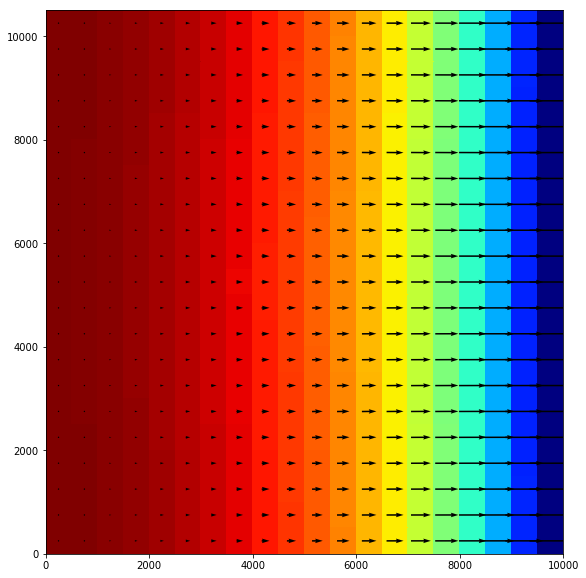

In [4]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()

fpth = os.path.join(ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

# make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
pmv.plot_array(hds, cmap='jet')
pmv.plot_specific_discharge(spd)

## Transient Model

We will now convert this steady state model into a transient model by going through several steps.  To make sure things are working properly, it is good practice to run the model after each step before going to the next step.

1. Copy the steady state code from above into the block below as a way to start.
2. Change the TDIS Package so that the simulation consists of a 1 day stress period followed by 10 yearly stress periods with monthly time steps.  
    * (e.g. perioddata = [(1., 1, 1.)] + [(365., 12, 1.2) for kper in range(10)])
3. Add a Storage Package with a specific yield of 0.2 and specific storage of 1.e-5 /m.  Set the first stress period to steady state and remaining stress periods to transient 
    * (e.g. steady_state = {0: True, 1: False} and transient = {0: False, 1: True}).
4. Modify the well package to use transient data.  We will have no pumping for the first stress period.  For remaining stress periods, use a random pumping rate between 0 and -15000 m^3/day in zero-based cellid (2, 10, 9).  For a real model these pumping rates could be read from a spreadsheet, database or other type of file.
5. Add an observation package (flopy.mf6.ModflowUtlobs) and observe the head in the well cell and the two overlying cells. 
    * (e.g. continuous = {obsoutputfile: [[obsname, obstype, (k, i, j)], ...]}
6. Create a plot that shows the head in the well cell and the two overyling cells as a function of time.  If time permits, show the well discharge rate as a bar chart on the same plot.
    * The pandas read_csv function is a quick way to get started with this plot.  For example, pd.read_csv(csvfile, index_col='time').plot(figsize=(15, 5), marker='o')
7.  Create an animation of model results in your notebook using the Ipython.display module.
8.  Extra credit (for later): change the river stage to vary monthly according to a sinusoidal  oscillating function.  

In [5]:
ws = 'data/ex03b'
name = 'ex03b'
exe_name = os.path.abspath('../bin/mf6')
assert os.path.isfile(exe_name)

# create simulation
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, sim_ws=ws)

# CHANGES FOR TRANSIENT SIMULATION
perioddata = [(1., 1, 1.)] + [(365., 12, 1.2) for kper in range(10)]
nper = len(perioddata)
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=perioddata)

ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

# dis
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220, 200, 0]
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# ic
ic = flopy.mf6.ModflowGwfic(gwf, strt=320.)

# npf
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype = [1, 0, 0]
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              save_specific_discharge=True,
                              icelltype=icelltype,
                              k=kh,
                              k33=kv)

# CHANGES FOR TRANSIENT SIMULATION
steady_state = {0: True, 1: False}
transient = {0: False, 1: True}
sto = flopy.mf6.ModflowGwfsto(gwf, sy=0.2, ss=1.e-5,
                              steady_state=steady_state, transient=transient)


# rch
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005)

# CHANGES FOR TRANSIENT SIMULATION (turn well on in second period with a random rate for each year)
# wel
wel_spd = {kper + 1: [[(2, 10, 9), -150000 * f]] for kper, f in enumerate(np.random.random(nper - 1))}
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                              stress_period_data=wel_spd)

# riv
riv_spd = {0: [[(0, i, 19), 320, 1e5, 318] for i in range(nrow)]}
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

# oc
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                            head_filerecord=hname,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# CHANGES FOR TRANSIENT SIMULATION
obsname = name + '.obs.csv'
continuous = {obsname: [['HWELL0', 'HEAD', (0, 10, 9)],
                        ['HWELL1', 'HEAD', (1, 10, 9)],
                        ['HWELL2', 'HEAD', (2, 10, 9)]]}
obs = flopy.mf6.ModflowUtlobs(gwf, continuous=continuous)

# Write files and run model
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex03b...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
    writing package obs_0...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software

(True, [])

### Plot Hydrograph for Well Location

In [6]:
qlist = [0]
for k in wel_spd:
    q = wel_spd[k][0][1]
    qlist.append(q)
pertimes = [pertim for pertim, _, _ in perioddata]
times = np.add.accumulate(np.array([0] + pertimes))

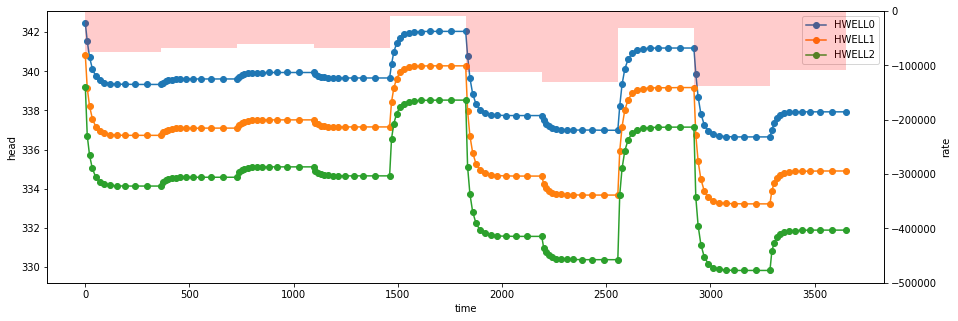

In [7]:
fpth = os.path.join(ws, obsname)
import pandas as pd
pd.read_csv(fpth, index_col='time').plot(figsize=(15, 5), marker='o')
plt.gca().set_ylabel('head')
ax2 = plt.gca().twinx()
ax2.bar(times[:-1], qlist, width=pertimes, align='edge', alpha=0.2, color='red')
ax2.set_ylim(-500000, 0)
ax2.set_ylabel('rate')

### Create Animation of Model Results

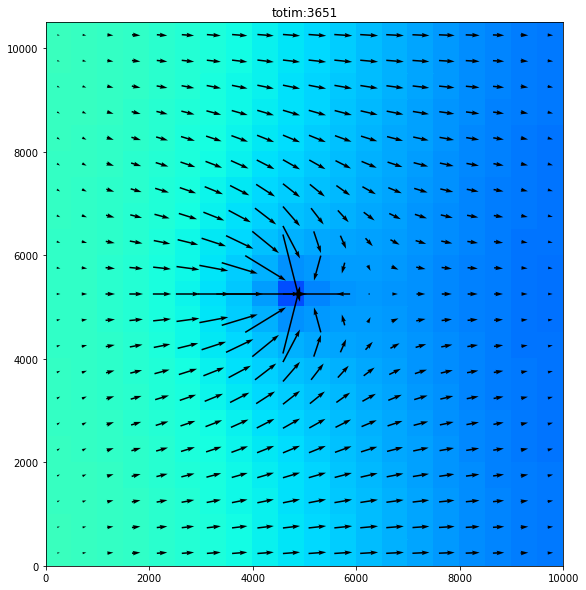

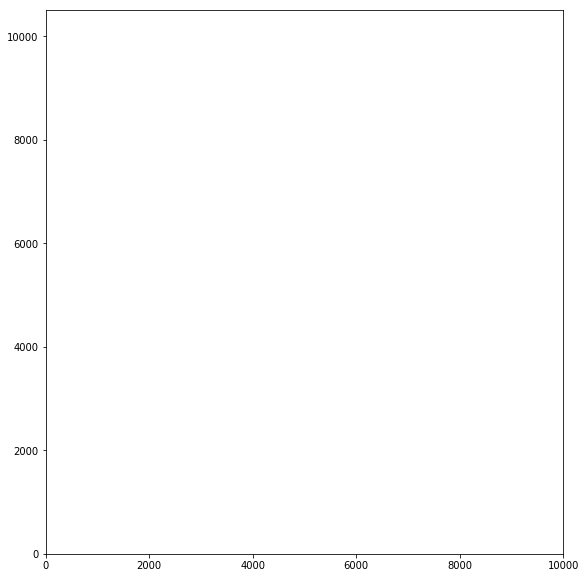

In [8]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_alldata()

ilay = 2
vmin = hds[:, ilay, :, :].min()
vmax = hds[:, ilay, :, :].max()

fpth = os.path.join(ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)
spd = cobj.get_data(text='DATA-SPDIS')

from IPython.display import clear_output, display
import time

# make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, layer=ilay, ax=ax)


for i, t in enumerate(hobj.get_times()):
    ax.set_title("totim:{0:.0f}".format(t))
    pmv.plot_array(hds[i], cmap='jet', vmin=vmin, vmax=vmax)
    pmv.contour_array(a=hds[0] - hds[i], levels=[.1, .5, 1, 5], colors='white')
    pmv.plot_specific_discharge(spd[i])
    time.sleep(0.1)
    clear_output(wait=True)
    display(fig)
    ax.cla()

# automate model

In [5]:
ws = 'data/ex03b'
name = 'ex03b'
exe_name = os.path.abspath('../bin/mf6')
assert os.path.isfile(exe_name)

In [10]:
def mymodflowmodel(hk):
# create simulation
    sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, sim_ws=ws)

    # CHANGES FOR TRANSIENT SIMULATION
    perioddata = [(1., 1, 1.)] + [(365., 12, 1.2) for kper in range(10)]
    nper = len(perioddata)
    tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=perioddata)

    ims = flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

    # dis
    nlay, nrow, ncol = 3, 21, 20
    delr = delc = 500.
    top = 400.
    botm = [220, 200, 0]
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # ic
    ic = flopy.mf6.ModflowGwfic(gwf, strt=320.)

    # npf
    kh = hk
    kv = [10, 0.01, 20]
    icelltype = [1, 0, 0]
    npf = flopy.mf6.ModflowGwfnpf(gwf, 
                                  save_specific_discharge=True,
                                  icelltype=icelltype,
                                  k=kh,
                                  k33=kv)

    # CHANGES FOR TRANSIENT SIMULATION
    steady_state = {0: True, 1: False}
    transient = {0: False, 1: True}
    sto = flopy.mf6.ModflowGwfsto(gwf, sy=0.2, ss=1.e-5,
                                  steady_state=steady_state, transient=transient)


    # rch
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005)

    # CHANGES FOR TRANSIENT SIMULATION (turn well on in second period with a random rate for each year)
    # wel
    wel_spd = {kper + 1: [[(2, 10, 9), -150000 * f]] for kper, f in enumerate(np.random.random(nper - 1))}
    wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                                  stress_period_data=wel_spd)

    # riv
    riv_spd = {0: [[(0, i, 19), 320, 1e5, 318] for i in range(nrow)]}
    riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

    # oc
    hname = '{}.hds'.format(name)
    cname = '{}.cbc'.format(name)
    oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                                head_filerecord=hname,
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

    # CHANGES FOR TRANSIENT SIMULATION
    obsname = name + '.obs.csv'
    continuous = {obsname: [['HWELL0', 'HEAD', (0, 10, 9)],
                            ['HWELL1', 'HEAD', (1, 10, 9)],
                            ['HWELL2', 'HEAD', (2, 10, 9)]]}
    obs = flopy.mf6.ModflowUtlobs(gwf, continuous=continuous)

    # Write files and run model
    sim.write_simulation()
    sim.run_simulation()
    
    fname = ws + '/' + name + '.obs.csv'
    df = pd.read_csv(fname, index_col= 'time')
    
    return df

In [11]:
hk = [100,1000,200]
mymodflowmodel(hk)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex03b...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
    writing package obs_0...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software

,HWELL0,HWELL1,HWELL2
time,,,
1.000000,332.22,330.66,330.40
10.221712,331.78,329.98,328.82
21.287767,331.44,329.57,328.30
34.567032,331.24,329.34,328.03
50.502151,331.14,329.23,327.89
69.624293,331.10,329.18,327.83
92.570864,331.08,329.16,327.81
120.106749,331.08,329.15,327.80
153.149811,331.07,329.15,327.80
